<img src='images/Northwind_ERD_updated.png.'>

# Question

### Do the changes in product pricing affect spending?

Both questions can be tested using a paired sample t-test.

# Hypothesis

## H0: no effect - there is no change to spending based on reorder or frieght costs
## HA: there is an effect - there is a change to spending based on reorder or frieght costs

## Feature: spending
## Target: reorder/frieght

# Methodology

To evaluate the data provided by Northwind_ERD, I have chosen to use the following steps:
- Obtain Data
- Scrub Data
- Explore Data
- Modeling
- Interpret

I have found that the OSEMN method explains the data science process, and gives context to exploring data.

# Obtain Data

The data we're evaluating comes from the 'Northwind_small.sqlite' file in this repository. We'll need to pull the following tables and the following lines of information:

- Product
    - ProductId
    - ReorderLevel
- Order
    - OrderId
    - ShipVia
    - Frieght
- OrderDetail
    - OrderId
    - ProductId
    - UnitPrice
    - Quantity

In [1]:
# import py file
from classes import Pvalue

In [2]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from scipy.stats import wilcoxon
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('Solarize_Light2')
import seaborn as sns

idx = pd.IndexSlice

### Setting up the connection with the database

In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

### Looking at the necessary data

In [4]:
# Order data
cur.execute("""SELECT *
               FROM 'Order';
               """)
df_order = pd.DataFrame(cur.fetchall())
df_order.columns = [x[0] for x in cur.description]
df_order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [5]:
# OrderDetail data
cur.execute("""SELECT *, UnitPrice*Quantity as OrderTotal
               FROM OrderDetail;
               """)
df_orderdetail = pd.DataFrame(cur.fetchall())
df_orderdetail.columns = [x[0] for x in cur.description]
df_orderdetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [6]:
df_orderdetail['ProductId'].max()

77

In [7]:
# Product data
cur.execute("""SELECT *
               FROM Product;
               """)
df_product = pd.DataFrame(cur.fetchall())
df_product.columns = [x[0] for x in cur.description]
df_product.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [8]:
# total number of prodcuts
len(df_product['ReorderLevel'])

77

In [9]:
# number of products without reorder
sum(df_product['ReorderLevel'] == 0)

24

In [10]:
df_product[df_product['ReorderLevel'] == 0].sample(10)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
52,53,Perth Pasties,24,6,48 pieces,32.80,0,0,0,1
9,10,Ikura,4,8,12 - 200 ml jars,31.00,31,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
23,24,Guaraná Fantástica,10,1,12 - 355 ml cans,4.50,20,0,0,1
46,47,Zaanse koeken,22,3,10 - 4 oz boxes,9.50,36,0,0,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
17,18,Carnarvon Tigers,7,8,16 kg pkg.,62.50,42,0,0,0
27,28,Rössle Sauerkraut,12,7,25 - 825 g cans,45.60,26,0,0,1
64,65,Louisiana Fiery Hot Pepper Sauce,2,2,32 - 8 oz bottles,21.05,76,0,0,0
7,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.00,6,0,0,0


In [11]:
# number of products with a reorder
sum(df_product['ReorderLevel'] != 0)

53

In [12]:
df_product[df_product['ReorderLevel'] != 0].sample(10)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
56,57,Ravioli Angelo,26,5,24 - 250 g pkgs.,19.50,36,0,20,0
54,55,Pâté chinois,25,6,24 boxes x 2 pies,24.00,115,0,20,0
22,23,Tunnbröd,9,5,12 - 250 g pkgs.,9.00,61,0,25,0
55,56,Gnocchi di nonna Alice,26,5,24 - 250 g pkgs.,38.00,21,10,30,0
73,74,Longlife Tofu,4,7,5 kg pkg.,10.00,4,20,5,0
42,43,Ipoh Coffee,20,1,16 - 500 g tins,46.00,17,10,25,0
63,64,Wimmers gute Semmelknödel,12,5,20 bags x 4 pieces,33.25,22,80,30,0
67,68,Scottish Longbreads,8,3,10 boxes x 8 pieces,12.50,6,10,15,0
30,31,Gorgonzola Telino,14,4,12 - 100 g pkgs,12.50,0,70,20,0
20,21,Sir Rodney's Scones,8,3,24 pkgs. x 4 pieces,10.00,3,40,5,0


It looks like there are duplicates because the index is the same, but the item total is different. I think it might be a good idea to incorporate the item number to ensure unique indexing.

In [13]:
# All data
cur.execute("""SELECT 'Order'.Id, OrderDate, ShipVia, Freight, Product.UnitPrice as ProductPrice, 
OrderDetail.UnitPrice as OrderPrice, Quantity, ReorderLevel, OrderDetail.ProductId, OrderDetail.Discount
               FROM OrderDetail
               LEFT JOIN 'Order' ON OrderDetail.OrderID = 'Order'.Id
               JOIN Product ON OrderDetail.ProductId = Product.Id
               ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderDate,ShipVia,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,ProductId,Discount
0,10248,2012-07-04,3,32.38,21.00,14.0,12,30,11,0.0
1,10248,2012-07-04,3,32.38,14.00,9.8,10,0,42,0.0
2,10248,2012-07-04,3,32.38,34.80,34.8,5,0,72,0.0
3,10249,2012-07-05,1,11.61,23.25,18.6,9,0,14,0.0
4,10249,2012-07-05,1,11.61,53.00,42.4,40,10,51,0.0


In [14]:
df_drop = df[df['ProductId']!=11]
df_drop = df_drop[df_drop['ProductId']!=42]

In [15]:
df_drop.tail()

,Id,OrderDate,ShipVia,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,ProductId,Discount
2150,11077,2014-05-06,2,8.53,33.25,33.25,2,30,64,0.03
2151,11077,2014-05-06,2,8.53,17.00,17.00,1,20,66,0.00
2152,11077,2014-05-06,2,8.53,15.00,15.00,2,5,73,0.01
2153,11077,2014-05-06,2,8.53,7.75,7.75,4,25,75,0.00
2154,11077,2014-05-06,2,8.53,13.00,13.00,2,15,77,0.00


In [16]:
# total number of orders to be evaluated
len(df_drop['Id'].unique())

822

In [17]:
df_drop['OrderDate'] = pd.to_datetime(df_drop['OrderDate'])

In [18]:
table = pd.pivot_table(data=df_drop, index=('Id', 'OrderDate', 'ShipVia', 'ProductId'), aggfunc=sum,)
table.head()

Discount  Freight  OrderPrice  \
Id    OrderDate  ShipVia ProductId                                  
10248 2012-07-04 3       72             0.00    32.38        34.8   
10249 2012-07-05 1       14             0.00    11.61        18.6   
                         51             0.00    11.61        42.4   
10250 2012-07-08 2       41             0.00    65.83         7.7   
                         51             0.15    65.83        42.4   

                                    ProductPrice  Quantity  ReorderLevel  
Id    OrderDate  ShipVia ProductId                                        
10248 2012-07-04 3       72                34.80         5             0  
10249 2012-07-05 1       14                23.25         9             0  
                         51                53.00        40            10  
10250 2012-07-08 2       41                 9.65        10            10  
                         51                53.00        35            10

In [19]:
df_drop.columns

Index(['Id', 'OrderDate', 'ShipVia', 'Freight', 'ProductPrice', 'OrderPrice',
       'Quantity', 'ReorderLevel', 'ProductId', 'Discount'],
      dtype='object')

In [20]:
multi = df_drop.copy(deep=True)
mulit = multi.set_index(['Id', 'OrderDate', 'ShipVia', 'ProductId'], inplace=True)
multi.head()

Freight  ProductPrice  OrderPrice  \
Id    OrderDate  ShipVia ProductId                                      
10248 2012-07-04 3       72           32.38         34.80        34.8   
10249 2012-07-05 1       14           11.61         23.25        18.6   
                         51           11.61         53.00        42.4   
10250 2012-07-08 2       41           65.83          9.65         7.7   
                         51           65.83         53.00        42.4   

                                    Quantity  ReorderLevel  Discount  
Id    OrderDate  ShipVia ProductId                                    
10248 2012-07-04 3       72                5             0      0.00  
10249 2012-07-05 1       14                9             0      0.00  
                         51               40            10      0.00  
10250 2012-07-08 2       41               10            10      0.00  
                         51               35            10      0.15

In [21]:
sort1 = multi.copy()
sort1.sort_index(inplace=True)
sort1.head(10)

Freight  ProductPrice  OrderPrice  \
Id    OrderDate  ShipVia ProductId                                      
10248 2012-07-04 3       72           32.38         34.80        34.8   
10249 2012-07-05 1       14           11.61         23.25        18.6   
                         51           11.61         53.00        42.4   
10250 2012-07-08 2       41           65.83          9.65         7.7   
                         51           65.83         53.00        42.4   
                         65           65.83         21.05        16.8   
10251 2012-07-08 1       22           41.34         21.00        16.8   
                         57           41.34         19.50        15.6   
                         65           41.34         21.05        16.8   
10252 2012-07-09 2       20           51.30         81.00        64.8   

                                    Quantity  ReorderLevel  Discount  
Id    OrderDate  ShipVia ProductId                                    
10248 2012-07-04 3       72                5             0      0.00  
10249 2012-07-05 1       14                9             0      0.00  
                         51               40            10      0.00  
10250 2012-07-08 2       41               10            10      0.00  
                         51               35            10      0.15  
                         65               15             0      0.15  
10251 2012-07-08 1       22                6            25      0.05  
                         57               15            20      0.05  
                         65               20             0      0.00  
10252 2012-07-09 2       20               40             0      0.05

In [22]:
# only shipping for company 1
company_1 = sort1.loc[idx[:, :, 1], :]
company_1.sample(10)

,,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,Discount
Id,OrderDate,ShipVia,ProductId,,,,,,
10327,2012-10-11,1,2,63.36,19.00,15.20,25,25,0.20
10954,2014-03-17,1,31,27.91,12.50,12.50,25,20,0.15
10913,2014-02-26,1,33,33.05,2.50,2.50,40,20,0.25
10379,2012-12-11,1,41,45.03,9.65,7.70,8,10,0.10
10745,2013-11-18,1,18,3.52,62.50,62.50,24,0,0.00
10932,2014-03-06,1,16,134.64,17.45,17.45,30,10,0.10
10745,2013-11-18,1,44,3.52,19.45,19.45,16,15,0.00
10625,2013-08-08,1,14,43.90,23.25,23.25,3,0,0.00
10851,2014-01-26,1,57,160.55,19.50,19.50,10,20,0.05


In [23]:
# only shipping for company 2
company_2 = sort1.loc[idx[:, :, 2], :]
company_2.sample(10)

,,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,Discount
Id,OrderDate,ShipVia,ProductId,,,,,,
10973,2014-03-24,2,41,15.17,9.65,9.65,6,10,0.00
10868,2014-02-04,2,35,191.27,18.00,18.00,30,15,0.00
10294,2012-08-30,2,1,147.26,18.00,14.40,18,10,0.00
10905,2014-02-24,2,1,13.72,18.00,18.00,20,10,0.05
10477,2013-03-17,2,1,13.02,18.00,14.40,15,10,0.00
10261,2012-07-19,2,21,3.05,10.00,8.00,20,5,0.00
10334,2012-10-21,2,52,8.56,7.00,5.60,8,25,0.00
11056,2014-04-28,2,60,278.96,34.00,34.00,50,0,0.00
10772,2013-12-10,2,59,91.28,55.00,55.00,25,0,0.00


In [24]:
# only shipping for company 3
company_3 = sort1.loc[idx[:, :, 3], :]
company_3.sample(10)

,,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,Discount
Id,OrderDate,ShipVia,ProductId,,,,,,
10773,2013-12-11,3,31,96.43,12.50,12.50,70,20,0.20
10785,2013-12-18,3,75,1.51,7.75,7.75,10,25,0.00
10383,2012-12-16,3,13,34.24,6.00,4.80,20,5,0.00
10681,2013-09-25,3,64,76.13,33.25,33.25,28,30,0.00
10679,2013-09-23,3,59,27.94,55.00,55.00,12,0,0.00
10620,2013-08-05,3,52,0.94,7.00,7.00,5,25,0.00
10751,2013-11-24,3,50,130.79,16.25,16.25,20,30,0.10
10308,2012-09-18,3,70,1.61,15.00,12.00,5,30,0.00
10751,2013-11-24,3,30,130.79,25.89,25.89,30,15,0.00


Insert commentary here about how there doesn't seems to be a pattern to the freight charges due to the company selected.

# Scrub Data

The following scrubbing techniques were applied to the original data:
- Manage n/a data types
- Delete duplicate rows
- Correct data types
- Find outliers

### Manage n/a data types

In [25]:
# nans identification
print(len(sort1))
sort1.isna().sum()

2087


Freight         0
ProductPrice    0
OrderPrice      0
Quantity        0
ReorderLevel    0
Discount        0
dtype: int64

### Delete duplicate data

In [26]:
# identification of duplicate data
print('duplicated rows: ' + str(sort1.duplicated().sum()))

duplicated rows: 0


In [27]:
# code to drop duplicate rows if necessary
# sort1.drop_duplicates(inplace=True)
# print('duplicated rows: ' + str(sort1.duplicated().sum()))

### Data types

First, let's see what the data types for this data set are.

In [28]:
# data type identification
sort1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2087 entries, (10248, 2012-07-04 00:00:00, 3, 72) to (11077, 2014-05-06 00:00:00, 2, 77)
Data columns (total 6 columns):
Freight         2087 non-null float64
ProductPrice    2087 non-null float64
OrderPrice      2087 non-null float64
Quantity        2087 non-null int64
ReorderLevel    2087 non-null int64
Discount        2087 non-null float64
dtypes: float64(4), int64(2)
memory usage: 121.1 KB


In [29]:
# A function to check our index level dtypes to aid this example
def index_level_dtypes(df):
    return [f"{df.index.names[i]}: {df.index.get_level_values(n).dtype}"
            for i, n in enumerate(df.index.names)]

index_level_dtypes(sort1)

['Id: int64',
 'OrderDate: datetime64[ns]',
 'ShipVia: int64',
 'ProductId: int64']

### Find outliers

length of cleaner dataset: 2087


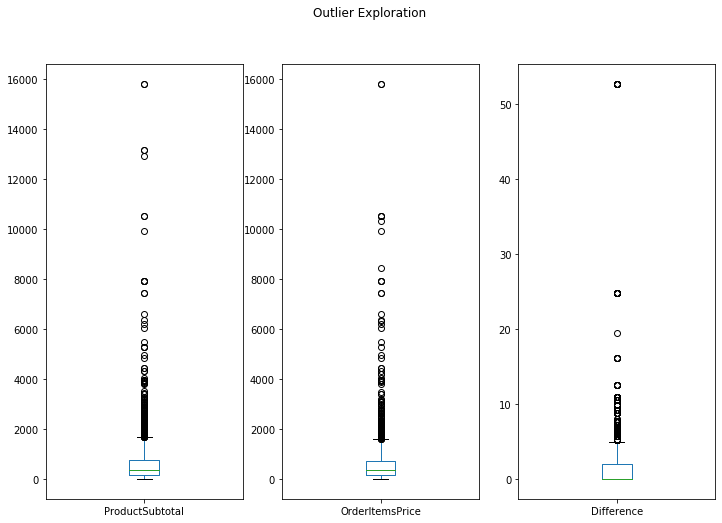

In [35]:
# outlier identification
print('length of cleaner dataset: ' + str(len(sort1)))

fig01 = plt.figure(figsize=(12,8))
fig01.suptitle('Outlier Exploration')

ax = fig01.add_subplot(131)
ax1 = sort1.ProductSubtotal.plot(kind='box')
ax = fig01.add_subplot(132)
ax2 = sort1.OrderItemsPrice.plot(kind='box')
ax = fig01.add_subplot(133)
ax3 = sort1.Difference.plot(kind='box')

length of cleaner dataset: 2050


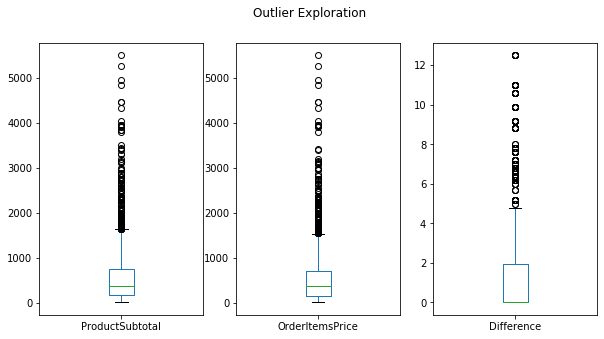

In [36]:
# management of outliers
no_outliers = sort1.loc[sort1['ProductSubtotal'] < 6000]
no_outliers = no_outliers.loc[no_outliers['OrderItemsPrice'] < 6000]
no_outliers = no_outliers.loc[no_outliers['Difference'] < 15]
print('length of cleaner dataset: ' + str(len(no_outliers)))

fig02 = plt.figure(figsize=(10,5))
fig02.suptitle('Outlier Exploration')

ax = fig02.add_subplot(131)
ax1 = no_outliers.ProductSubtotal.plot(kind='box')
ax = fig02.add_subplot(132)
ax2 = no_outliers.OrderItemsPrice.plot(kind='box')
ax = fig02.add_subplot(133)
ax3 = no_outliers.Difference.plot(kind='box')

### Develop feature

It would be useful to be able to evaluate the total amount for each item in an order.

In [30]:
sort1['ProductSubtotal'] = sort1['ProductPrice'] * sort1['Quantity']
sort1.sample(10)

,,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,Discount,ProductSubtotal
Id,OrderDate,ShipVia,ProductId,,,,,,,
11001,2014-04-06,2,22,197.30,21.00,21.0,25,25,0.00,525.00
10291,2012-08-27,2,44,6.40,19.45,15.5,24,15,0.10,466.80
10890,2014-02-16,1,17,32.76,39.00,39.0,15,0,0.00,585.00
11023,2014-04-14,2,43,123.83,46.00,46.0,30,25,0.00,1380.00
10256,2012-07-15,2,53,13.97,32.80,26.2,15,0,0.00,492.00
10389,2012-12-20,2,70,47.42,15.00,12.0,30,30,0.00,450.00
10478,2013-03-18,3,10,4.81,31.00,24.8,20,0,0.05,620.00
10902,2014-02-23,1,55,44.15,24.00,24.0,30,20,0.15,720.00
10444,2013-02-12,3,26,3.50,31.23,24.9,15,0,0.00,468.45


In [31]:
sort1['OrderItemsPrice'] = sort1['OrderPrice'] * sort1['Quantity']
sort1.sample(10)

,,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,Discount,ProductSubtotal,OrderItemsPrice
Id,OrderDate,ShipVia,ProductId,,,,,,,,
10790,2013-12-22,1,7,28.23,30.00,30.00,3,10,0.15,90.00,90.00
10607,2013-07-22,1,17,200.24,39.00,39.00,100,0,0.00,3900.00,3900.00
10936,2014-03-09,2,36,33.68,19.00,19.00,30,20,0.20,570.00,570.00
10373,2012-12-05,3,71,124.12,21.50,17.20,50,0,0.20,1075.00,860.00
10592,2013-07-08,1,15,32.10,15.50,15.50,25,5,0.05,387.50,387.50
10832,2014-01-14,2,64,43.26,33.25,33.25,3,30,0.00,99.75,99.75
10841,2014-01-20,2,77,424.30,13.00,13.00,15,15,0.00,195.00,195.00
10328,2012-10-14,3,59,87.03,55.00,44.00,9,0,0.00,495.00,396.00
10959,2014-03-18,2,75,4.98,7.75,7.75,20,25,0.15,155.00,155.00


In [32]:
sort1['Difference'] = sort1['ProductPrice'] - sort1['OrderPrice']
sort1.sample(10)

,,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,Discount,ProductSubtotal,OrderItemsPrice,Difference
Id,OrderDate,ShipVia,ProductId,,,,,,,,,
10262,2012-07-22,3,7,48.29,30.0,24.0,15,10,0.00,450.0,360.0,6.0
10354,2012-11-14,3,1,53.80,18.0,14.4,12,10,0.00,216.0,172.8,3.6
10504,2013-04-11,3,2,59.13,19.0,19.0,12,25,0.00,228.0,228.0,0.0
10719,2013-10-27,2,18,51.44,62.5,62.5,12,0,0.25,750.0,750.0,0.0
10583,2013-06-30,2,60,7.28,34.0,34.0,24,0,0.15,816.0,816.0,0.0
10700,2013-10-10,1,34,65.10,14.0,14.0,12,15,0.20,168.0,168.0,0.0
10863,2014-02-02,2,1,30.26,18.0,18.0,20,10,0.15,360.0,360.0,0.0
10932,2014-03-06,1,72,134.64,34.8,34.8,16,0,0.00,556.8,556.8,0.0
11054,2014-04-28,1,33,0.33,2.5,2.5,10,20,0.00,25.0,25.0,0.0


In [33]:
len(sort1['Difference'])

2087

In [34]:
sum(sort1['Difference'] != 0)

638

# Explore Data

For a quick preview of what we have to work with, we'll use the describe method.

In [37]:
# describe data
no_outliers.describe()

,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,Discount,ProductSubtotal,OrderItemsPrice,Difference
count,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.00000,2050.000000,2050.000000,2050.000000
mean,92.484517,25.715054,24.309390,23.696585,11.839024,0.05602,587.576034,552.128873,1.405663
std,125.486610,23.725623,23.510391,18.876073,10.618199,0.08322,664.987193,635.145555,2.644466
min,0.020000,2.500000,2.000000,1.000000,0.000000,0.00000,6.000000,4.800000,0.000000
25%,18.690000,12.500000,12.000000,10.000000,0.000000,0.00000,164.400000,152.000000,0.000000
50%,53.050000,19.000000,18.400000,20.000000,10.000000,0.00000,376.500000,360.000000,0.000000
75%,116.430000,34.000000,31.230000,30.000000,20.000000,0.10000,756.000000,710.375000,1.950000
max,1007.640000,263.500000,263.500000,130.000000,30.000000,0.25000,5500.000000,5500.000000,12.500000


So far, the best looking data is quantity. However, our target information is Item Total.

### Visualize data

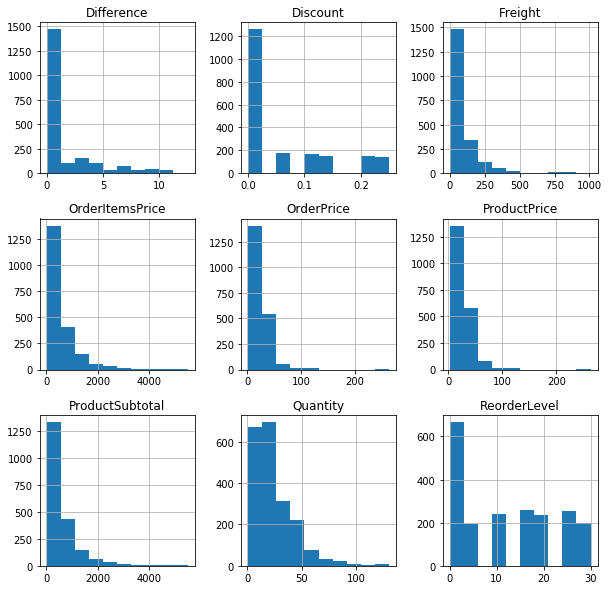

In [38]:
# visualize data
no_outliers.hist(figsize=(10,10));

This data looks like it needs a log transformation to be predictable. Alternatively, a non-parametric test could be used on the original data.

### Log Transformation

In [39]:
# # sort data
log_orderItemsPrice = no_outliers['OrderItemsPrice'].map(lambda x: np.log(x))
log_productSubtotal = no_outliers['ProductSubtotal'].map(lambda x: np.log(x))

no_outliers['OrderItemsPrice'] = log_orderItemsPrice
no_outliers['ProductSubtotal'] = log_productSubtotal

Observations about sorted data

# Model Data
Below is the model after scrubbing and exploring have been managed, let's see what the model picks up.

### Data normality

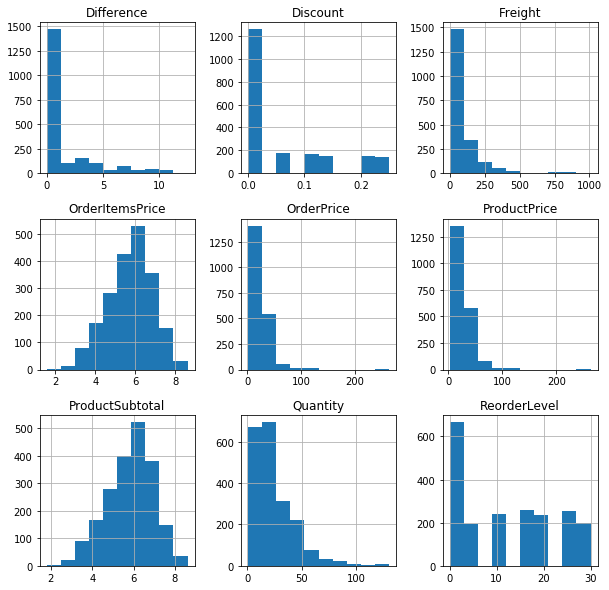

In [40]:
# visual/code for data normality
no_outliers.hist(figsize=(10,10));

### Standard deviation

In [41]:
# standard deviation for target variable
print('ProductSubtotal')
print('mean: ' + str(mean(no_outliers['ProductSubtotal'])))
print('standard deviation: ' + str(std(no_outliers['ProductSubtotal'])))

print('OrderDetailSubtotal')
print('mean: ' + str(mean(no_outliers['OrderItemsPrice'])))
print('standard deviation: ' + str(std(no_outliers['OrderItemsPrice'])))

ProductSubtotal
mean: 5.824025790457207
standard deviation: 1.1273701424031115
OrderDetailSubtotal
mean: 5.756912273608869
standard deviation: 1.1291870504369397


Definately use non-parametric testing

### Basic testing

In [42]:
# set up variables for this particular test
product = no_outliers['ProductSubtotal']
orderDetail = no_outliers['OrderItemsPrice']
alpha = 0.05

In [43]:
# test
stats.ttest_rel(product, orderDetail)

Ttest_relResult(statistic=29.59716647892667, pvalue=1.3721240988859291e-160)

In [44]:
# result
p_value = 4.825700370439923 * 10**-171

In [45]:
# evaluation of result
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


Preliminarily, we can reject the null hypothesis in favor of the idea that unit price from the Product table and unit price from the OrderDetail table are different. That can mean one of two things, either the Product table unit price includes the discount, or that the product mark up is effective. Let's verify these results.

Summarize results and determine next steps. Might include verification of sample size, error types, non-parametric testing, or a deepening of understanding

### Verification techniques
#### Non-parametric testing

##### H0: the distributions of both samples are equal.
##### H1: the distributions of both samples are not equal.

In [46]:
# non-parametric testing variables are the same as the testing above
# non-parametric test
stats.wilcoxon(product, orderDetail)

WilcoxonResult(statistic=0.0, pvalue=1.9746463031754043e-109)

In [47]:
# result
p_value = 3.4779637831744666 * 10**-116

In [48]:
# evaluation of results
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


This rejection is even more confident.

#### Effect size

In [49]:
# effect size variables
pass

In [50]:
# effect size test
def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
effect_size = cohen_d_two_samp(product, orderDetail)
effect_size

0.05946857820814

This effect size is miniscual. There is very little effect of the product unit price on the order detail unit price.

#### Power and error

In [51]:
# power variables
effect_size, nobs1, alpha = effect_size, product.shape[0], alpha

In [52]:
# power test
power = tt_ind_solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha)
power

0.4775329382033766

In [53]:
# power result
p_value = ''

In [54]:
# evaluation of power test
type_2_error = 1 - power
type_2_error

0.5224670617966234

There is a high chance (around 50%) that we have rejected the null hypothesis in error. It might be wise to expand testing.

### Cross validatation

In [55]:
# test train split for testing preformed above
pass

### Extension of acquired knowledge
#### Deeper question
#### Hypothesis for deeper question

In [56]:
# deeper understanding variables
pass

In [57]:
#unique product ids
unique_product_ids = df_drop.ProductId.unique()
unique_product_ids

count_unique_product_prices = [len(sort1[sort1.index.get_level_values(3) == x]['OrderPrice'].unique()) for x in unique_product_ids]
count_unique_product_prices

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [58]:
product_prices = df_drop[['ProductId', 'ProductPrice']].sort_values('ProductId').groupby('ProductId').mean().ProductPrice
product_prices

ProductId
1     18.00
2     19.00
3     10.00
4     22.00
5     21.35
      ...  
73    15.00
74    10.00
75     7.75
76    18.00
77    13.00
Name: ProductPrice, Length: 75, dtype: float64

In [59]:
order_prices = df_drop[['ProductId', 'OrderPrice']].sort_values('ProductId').groupby('ProductId').mean().OrderPrice
order_prices

ProductId
1     17.147368
2     17.877273
3      9.500000
4     20.680000
5     19.610000
        ...    
73    14.357143
74     8.769231
75     7.379348
76    16.984615
77    12.110526
Name: OrderPrice, Length: 75, dtype: float64

In [60]:
# deeper understanding test
stats.ttest_rel(product_prices, order_prices)

Ttest_relResult(statistic=6.882288190488461, pvalue=1.6279818776113184e-09)

In [61]:
# deeper understanding result
p_value = 1.6279818776113184*10**-9

In [62]:
# deeper understanding evaluation of result
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


Observations based off of deeper understanding test

# Interpret

Conclusions about question overall commentary on hypothesis

### Additional visualizations

In [63]:
# visual for blah blah blah
df['ProductId'].unique()

array([11, 42, 72, 14, 51, 41, 65, 22, 57, 20, 33, 60, 31, 39, 49, 24, 55,
       74,  2, 16, 36, 59, 53, 77, 27,  5, 32, 21, 37, 62, 70, 35,  7, 56,
       30, 17, 12, 40, 76, 29, 43, 10, 71, 13, 28, 44, 63, 73, 75, 19, 15,
       67,  1, 34, 46, 54, 68,  3, 64, 18, 69, 66,  4,  6, 58, 52, 25, 38,
       26, 47, 23,  8, 50, 45, 48, 61,  9], dtype=int64)

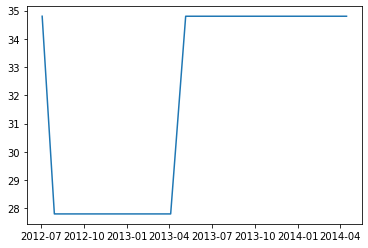

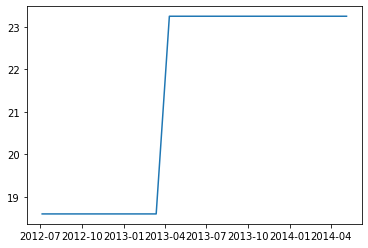

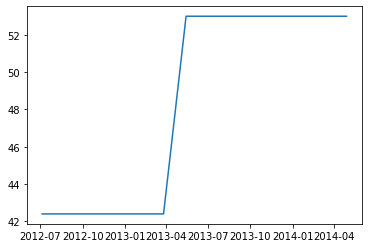

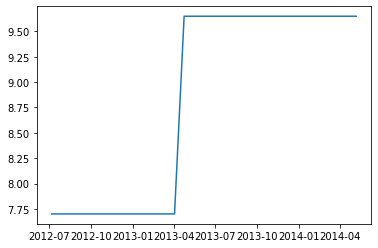

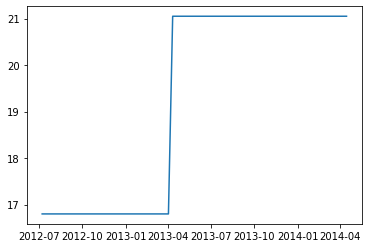

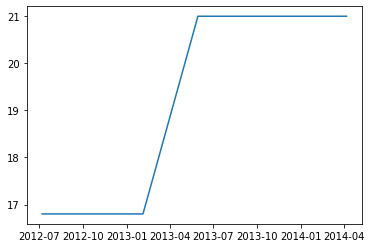

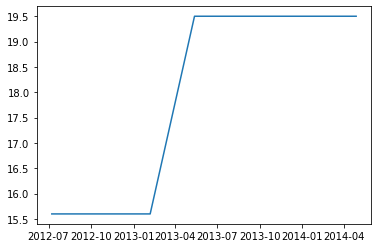

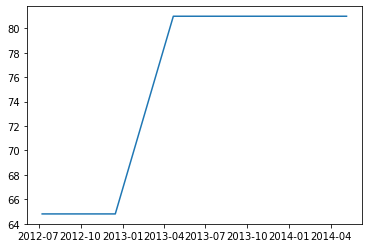

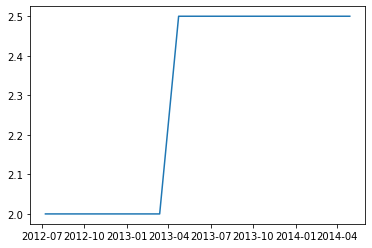

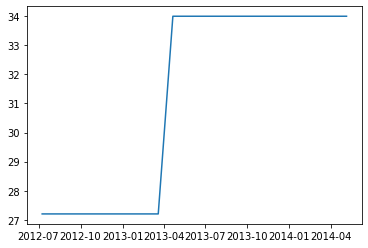

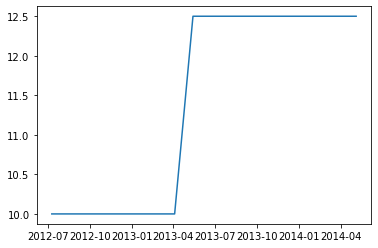

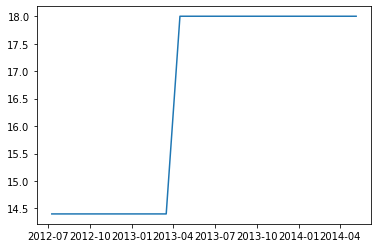

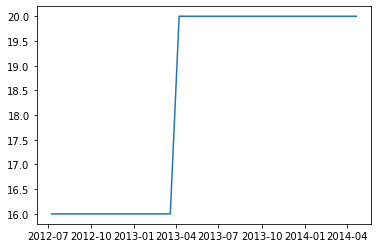

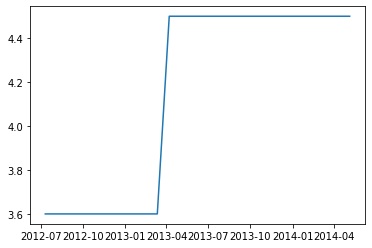

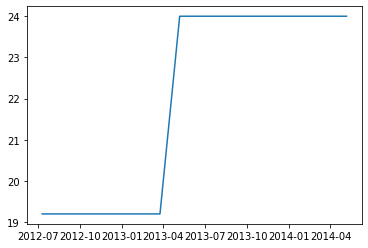

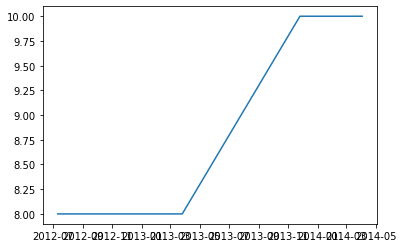

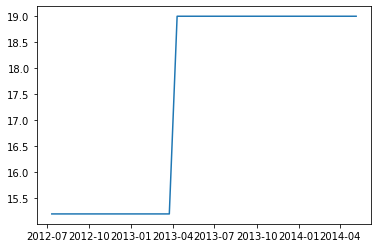

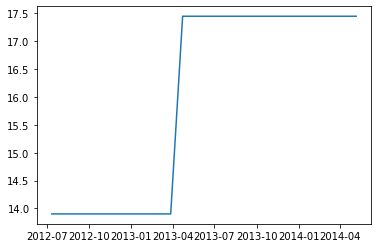

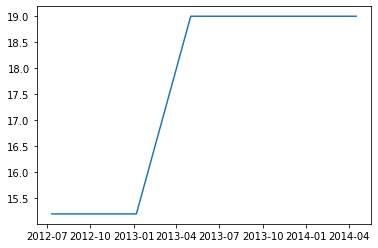

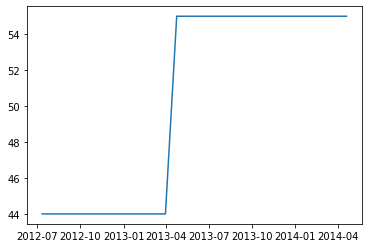

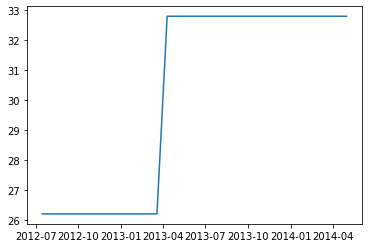

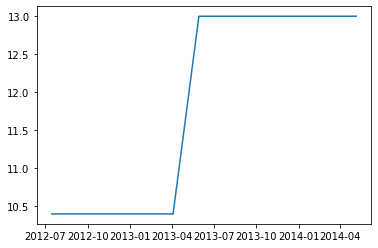

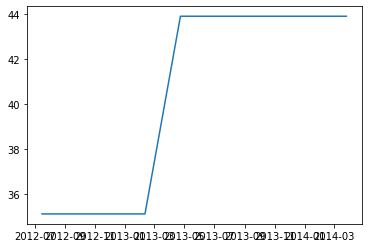

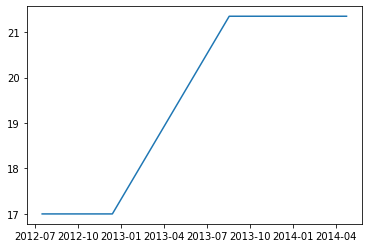

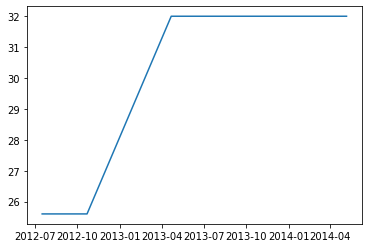

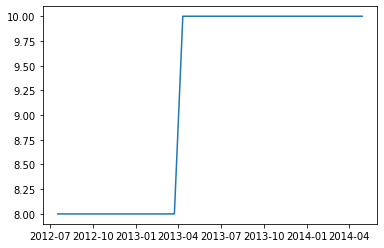

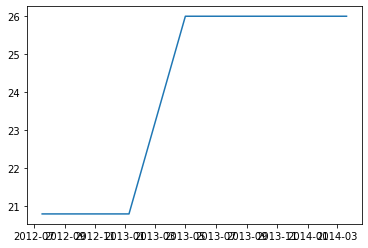

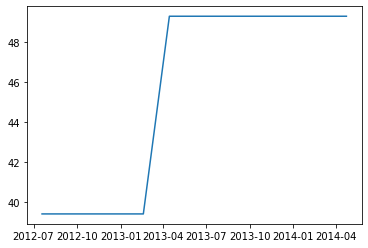

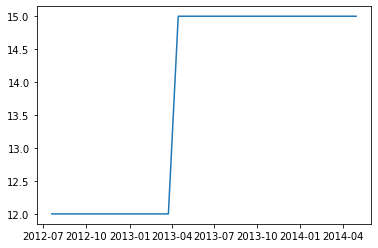

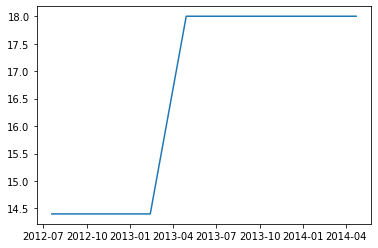

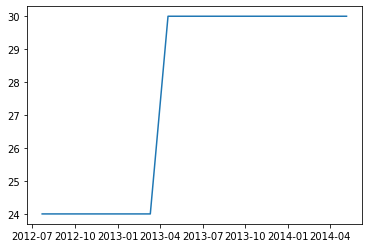

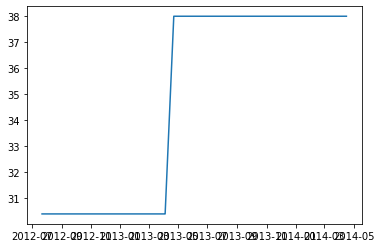

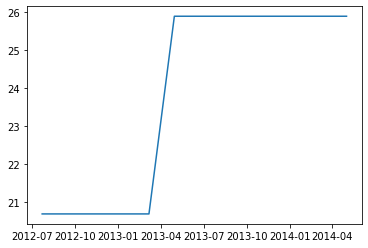

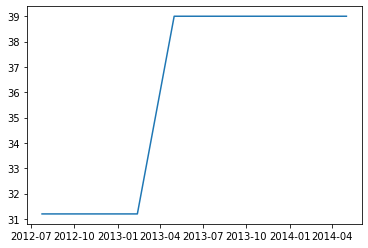

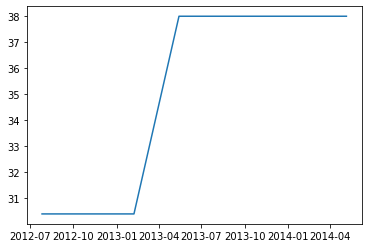

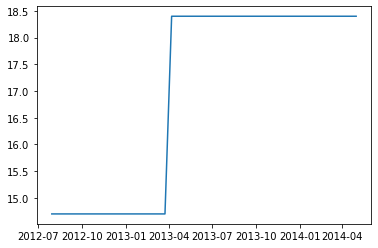

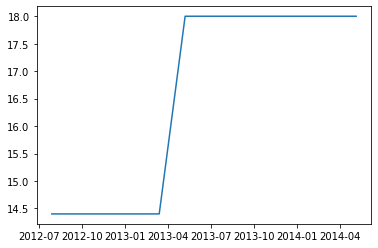

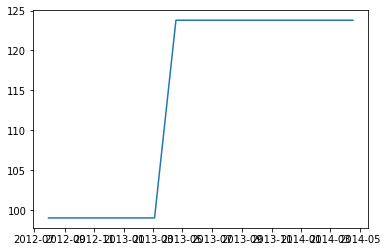

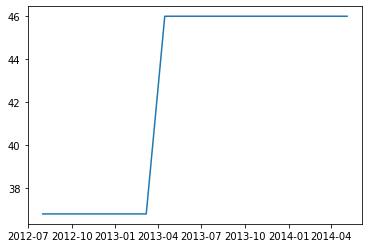

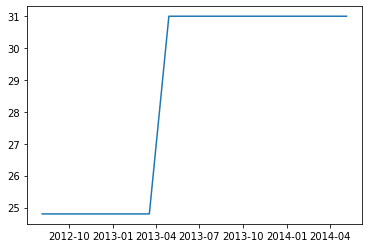

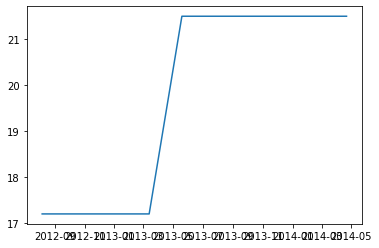

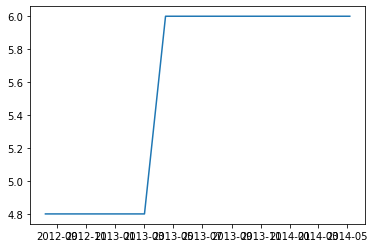

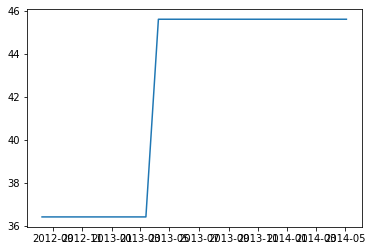

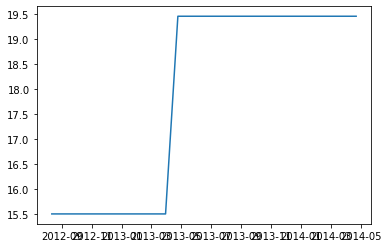

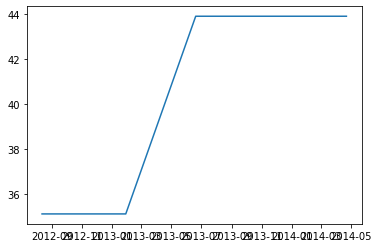

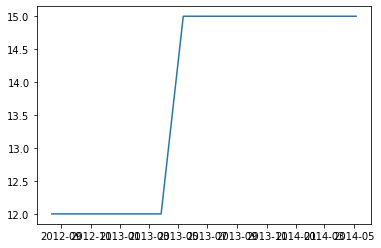

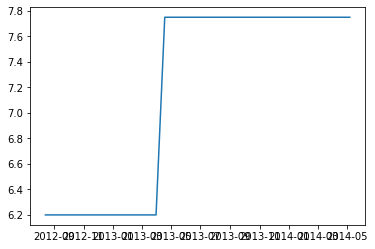

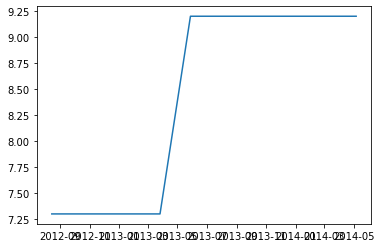

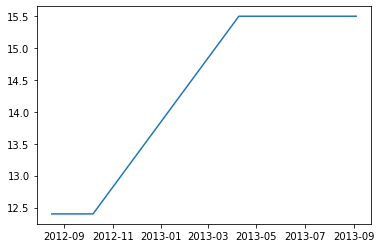

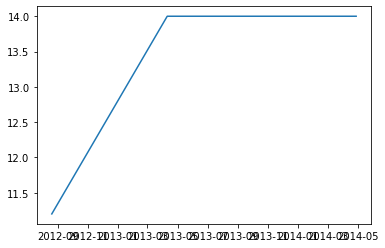

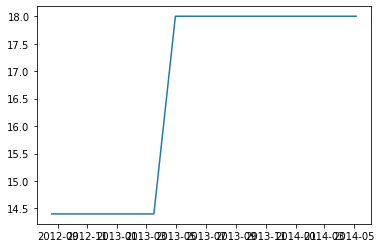

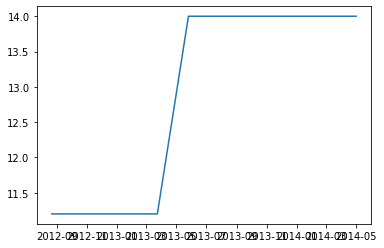

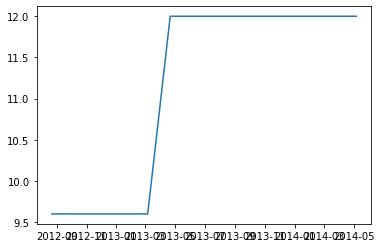

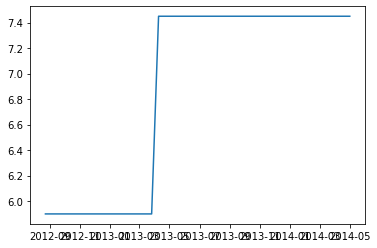

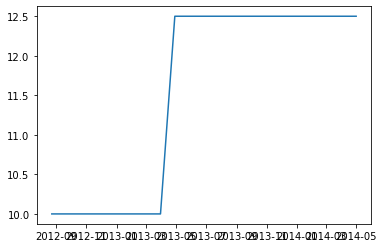

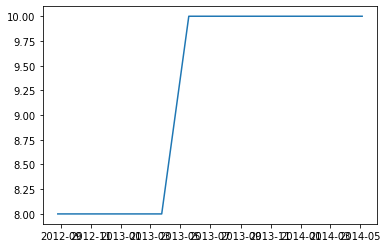

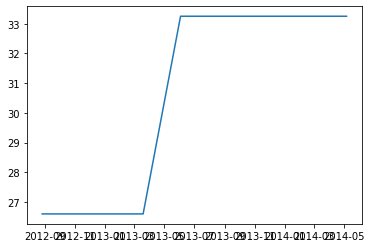

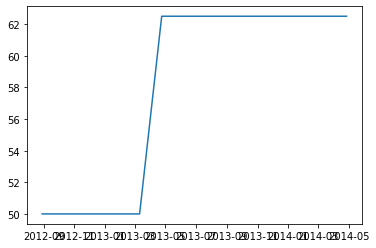

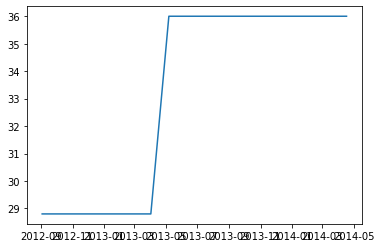

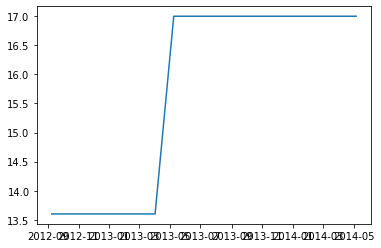

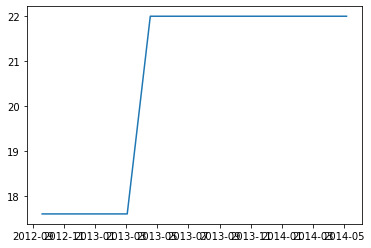

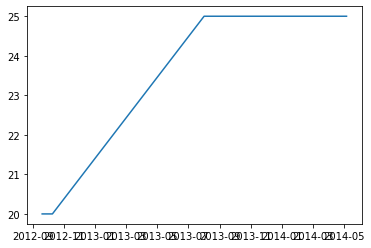

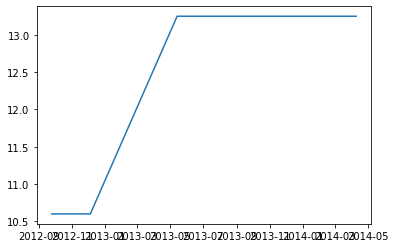

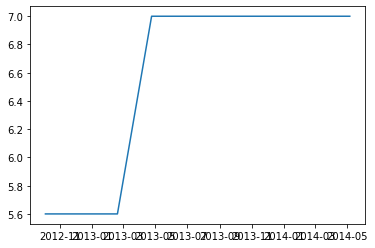

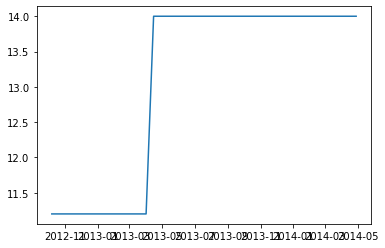

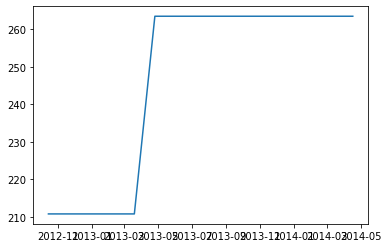

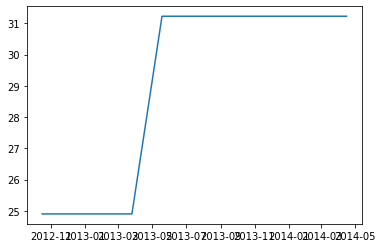

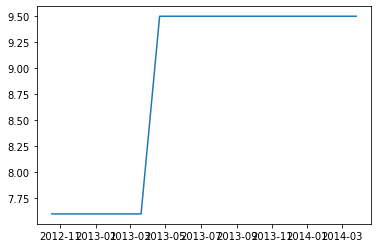

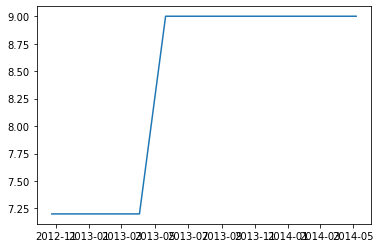

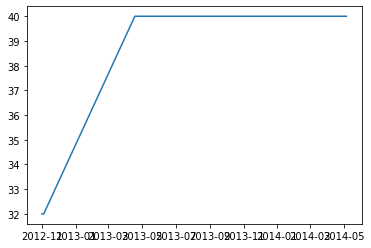

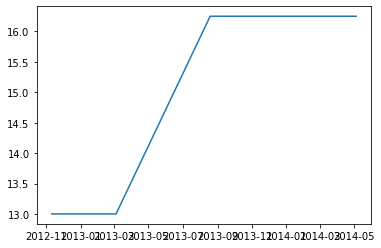

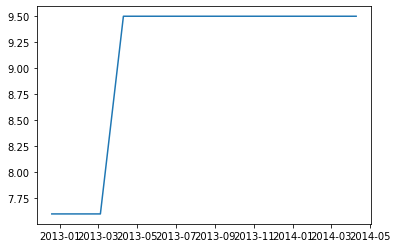

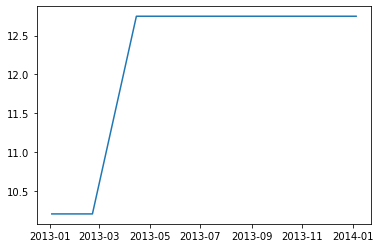

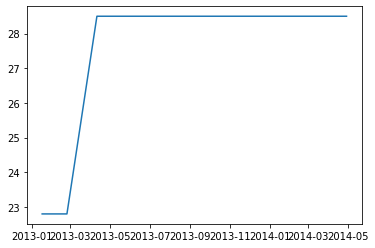

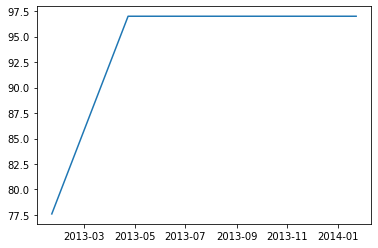

In [64]:
for i in df_drop['ProductId'].unique():
    plt.plot(df_drop[df_drop['ProductId']==i]['OrderDate'], df_drop[df_drop['ProductId']==i]['OrderPrice'])
    plt.show()

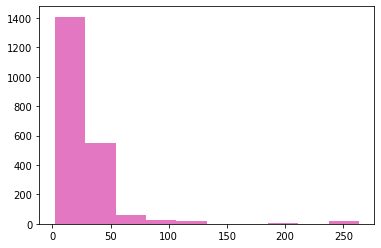

In [66]:
for i in df_drop.OrderDate.unique():
    plt.hist(df_drop['OrderPrice'])

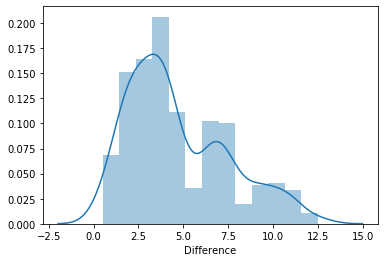

In [67]:
sns.distplot(no_outliers[no_outliers['Difference'] != 0]['Difference']);

### Tools for use of discovered information

In [68]:
# function or equation used to test developed theories
pass

# Future Work

Determine the best seasonality for a price change

# Resources

MultiIndexing Data
http://zaxrosenberg.com/pandas-multiindex-tutorial/
https://www.youtube.com/watch?v=kP-0ET0V5Tc